In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.neighbors
import sklearn.cluster
import sklearn.preprocessing
import datetime

## **Load and clean dataset**

Fonction de chargement des DataFrames

In [2]:
def load_and_clean_df_air(nom_fichier,nom_station,dropna):
    # --Voir notebook 'explore_df_air' pour des explications sur ce qui est fait en terme de nettoyage
    
    df_air=pd.read_csv(nom_fichier,delimiter=';')
    
    # Conversion de la donnée temporelle en objet datetime
    df_air=df_air.rename(columns={df_air.columns[0]:df_air.columns[0].lower()})
    df_air['date/heure']=df_air['date/heure'].str.extract('([^+]*)')
    df_air['date/heure']=pd.to_datetime(df_air['date/heure'])
    
    # Passage du CO2 à droite pour pouvoir l'isoler plus facilement (autre échelle) et suppression du PM 2.5 qui n'existe qu'à Auber
    df_air=df_air[['date/heure','NO','NO2','PM10','TEMP','HUMI','CO2']]
    
    # Nettoyage des données numériques
    df_air=df_air.replace('ND',np.nan)
    df_air[['NO','PM10']]=df_air[['NO','PM10']].applymap(lambda x : re.search('(\d+)',x).group(1)  if pd.notnull(x) else np.nan)
    df_air[['TEMP','HUMI']]=df_air[['TEMP','HUMI']].applymap(lambda x : x.replace(',','.') if pd.notnull(x) else np.nan)
    df_air[df_air.columns[1:]]=df_air[df_air.columns[1:]].astype(float)
    
    print(f'    Au départ :')
    print(f'% NaN (dont ND convertis) : {round(df_air.isna().sum().sum()/df_air.size*100,1)}%')
    print(f'% lignes avec NaN (dont ND convertis) : {round(df_air.isnull().any(axis=1).sum()/df_air.shape[0]*100,1)}%')
    
    # Complétion de la série temporelle et passage en index
    df_air=df_air.groupby('date/heure').mean()
    full_index = pd.date_range(start=df_air.index[0], end=df_air.index[-1], freq='H')
    df_air=df_air.reindex(full_index)
    df_air.index=df_air.index.set_names('date-heure')
    df_air.columns=df_air.columns.set_names('param')
    
    print(f'    Après réindexation :')
    print(f'% NaN (dont ND convertis) : {round(df_air.isna().sum().sum()/df_air.size*100,1)}%')
    print(f'% lignes avec NaN (dont ND convertis) : {round(df_air.isnull().any(axis=1).sum()/df_air.shape[0]*100,1)}%')
    
    #--Ajout du nom de la station à l'index - Passage en multiindex
    df_air['station']=nom_station
    df_air=df_air.set_index(['station'],append=True)
    
    # Interpolation pour "sauver" les lignes qui peuvent l'être
    df_air=df_air.sort_index()
    df_air=df_air.interpolate(limit=3) # On interpole jusqu'à 2 NaN consécutif. Au dela, on laisse les NaN
    # Rq : interpolate et limit fonctionnent tel que si on a un trou de 10 valeurs, il va interpoler le 2 premières en se basant sur la précédente et la onzième
    
    print(f'    Après interpolation :')
    print(f'% NaN (dont ND convertis) : {round(df_air.isna().sum().sum()/df_air.size*100,1)}%')
    print(f'% lignes avec NaN (dont ND convertis) : {round(df_air.isnull().any(axis=1).sum()/df_air.shape[0]*100,1)}%\n')
    
    # Suppression des lignes contenant des NaN et mise au format définitif
    if dropna==True:
        df_air=df_air.dropna()
        df_air[['NO','NO2','PM10','CO2']]=df_air[['NO','NO2','PM10','CO2']].astype(int)
    
    return df_air

### **Etude des valeurs nulles**

Chargement des dataframes à partir des 3 csv source et concaténation dans un dataframe global, en gardant les valeurs nulles

In [3]:
path = '1 - Données brutes/qualite_air_stations/'

# Chargement Franklin
print('FRANKLIN ROOSEVELT\n')
df_air_frkl=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt.csv',nom_station='frkl',dropna=False)
print(df_air_frkl)
# df_air_frkl.info()
# print()

# Chargement Chatelet
print('CHATELET\n')
df_air_chtlt=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-chatelet.csv',nom_station='chtlt',dropna=False)
print(df_air_chtlt)
# df_air_chtlt.info()
# print()

# Chargement Auber
print('AUBER\n')
df_air_abr=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-auber.csv',nom_station='abr',dropna=False)
print(df_air_abr)
# df_air_chtlt.info()

# Chargement d'un dataset global
print('GLOBAL\n')
list_df_air=[df_air_frkl,df_air_chtlt,df_air_abr]
df_air_global=pd.concat(list_df_air)
print(df_air_global)

print("\nChaque station est indexée sur toutes les heures de la première mesure à la dernière mesure : les sous-dataframes associés à chaque station ont donc le même nombre de lignes et de colonnes")

FRANKLIN ROOSEVELT

    Au départ :
% NaN (dont ND convertis) : 5.9%
% lignes avec NaN (dont ND convertis) : 19.6%
    Après réindexation :
% NaN (dont ND convertis) : 7.1%
% lignes avec NaN (dont ND convertis) : 19.9%
    Après interpolation :
% NaN (dont ND convertis) : 5.9%
% lignes avec NaN (dont ND convertis) : 15.6%

param                          NO   NO2  PM10  TEMP  HUMI    CO2
date-heure          station                                     
2013-01-01 02:00:00 frkl     23.0  41.0  26.0  15.1  65.6  612.0
2013-01-01 03:00:00 frkl     43.0  61.0  18.0  14.9  65.0  536.0
2013-01-01 04:00:00 frkl     22.0  52.0  45.0  14.9  63.3  490.0
2013-01-01 05:00:00 frkl     27.0  56.0  22.0  14.9  63.7  481.0
2013-01-01 06:00:00 frkl     27.0  57.0  15.0  15.0  63.3  464.0
...                           ...   ...   ...   ...   ...    ...
2021-10-17 22:00:00 frkl      5.0  37.0  50.0  19.9  39.6  551.0
2021-10-17 23:00:00 frkl      7.0  40.0  48.0  20.2  40.8  532.0
2021-10-18 00:00:00 frkl 

- **% de valeurs nulles par station**

La station auber a 40% de valeurs nulles : elle introduit plus de valeurs nulles que les deux autres stations réunies


station
abr      45.0
chtlt    20.1
frkl      5.9
dtype: float64

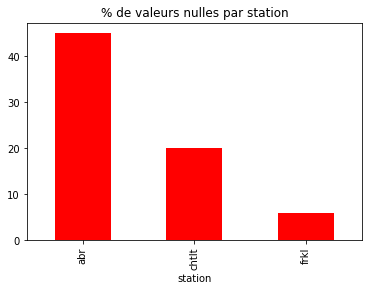

In [4]:
count_null=df_air_global.isnull().groupby("station").sum().sum(axis=1).div(df_air_global.groupby("station").size()*df_air_global.shape[1])
count_null=round(count_null*100,1)
count_null.plot.bar(title="% de valeurs nulles par station",color='r')
print("La station auber a 40% de valeurs nulles : elle introduit plus de valeurs nulles que les deux autres stations réunies")
count_null

- **% de valeurs nulles par paramètre**

Globalement les valeurs nulles sont réparties de manière équitable entre les paramètres, il n'y a pas un paramètre particulièrement problématique


param
NO      30.0
NO2     26.3
PM10    21.7
TEMP    19.9
HUMI    19.9
CO2     24.3
dtype: float64

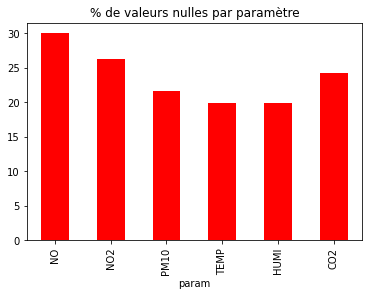

In [5]:
count_null=df_air_global.isnull().sum()/len(df_air_global)
count_null=round(count_null*100,1)
count_null.plot.bar(title="% de valeurs nulles par paramètre",color='r')
print('Globalement les valeurs nulles sont réparties de manière équitable entre les paramètres, il n\'y a pas un paramètre particulièrement problématique')
count_null

- **% de valeurs nulles par année**

In [6]:
df_air_global.isnull().groupby(df_air_global.index.get_level_values('date-heure').year).sum().sum(axis=1)

date-heure
2013     14903
2014     13045
2015      5610
2016     10428
2017      9929
2018    102800
2019     57347
2020     66064
2021     48486
dtype: int64

Il manque plus de 60% des valeurs sur l'année 2018, et autour de 40% sur les années 2018 à 2021


date-heure
2013     9.5
2014     8.3
2015     3.6
2016     6.6
2017     6.3
2018    65.2
2019    36.4
2020    41.8
2021    38.7
dtype: float64

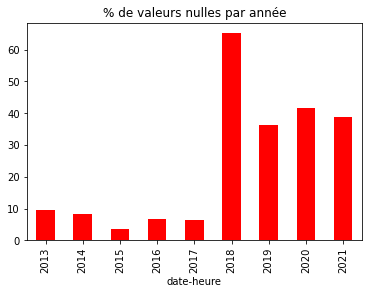

In [7]:
count_null=df_air_global.isnull().groupby(df_air_global.index.get_level_values('date-heure').year).sum().sum(axis=1).div(df_air_global.groupby(df_air_global.index.get_level_values('date-heure').year).size()*df_air_global.shape[1])
count_null=round(count_null*100,1)
count_null.plot.bar(title="% de valeurs nulles par année",color='r')
print("Il manque plus de 60% des valeurs sur l'année 2018, et autour de 40% sur les années 2018 à 2021")
count_null

- **% de valeurs nulles par couple paramètre-station**

station,abr,chtlt,frkl
param,,,
CO2,46.1,18.6,8.3
HUMI,43.2,13.9,2.6
NO,47.0,33.3,9.7
NO2,46.9,22.9,9.0
PM10,43.7,18.0,3.4
TEMP,43.2,13.9,2.6


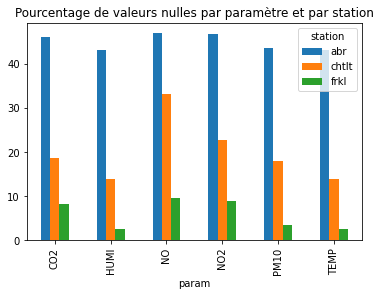

In [8]:
nb_null_per_param_per_station=df_air_global.isnull().groupby("station").sum().transpose()
nb_val_per_param_per_station=df_air_global.unstack(1).stack(0,dropna=0).groupby("param").size() # meme nombre de valeurs pour toutes les stations car réindexé toutes les heures
count_null=nb_null_per_param_per_station.div(nb_val_per_param_per_station,axis=0)
count_null=round(count_null*100,1)
count_null.plot.bar(title='Pourcentage de valeurs nulles par paramètre et par station');
count_null

- **% de valeurs nulles par couple station-année**

On ne dispose d'aucune valeur pour la station Auber à partir de 2018
On ne dispose quasiment d'aucune valeur pour la station Chatelet sur l'année 2018


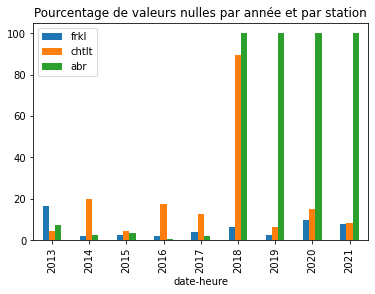

In [9]:
def sum_null_per_year_per_station(df_air_station):
    return df_air_station.isnull().groupby(df_air_station.index.get_level_values('date-heure').year).sum().sum(axis=1)
def nb_val_per_year_per_station(df_air_station):
    return df_air_station.groupby(df_air_station.index.get_level_values('date-heure').year).size()*df_air_station.shape[1]

count_null=pd.DataFrame({})
count_null['frkl']=round(sum_null_per_year_per_station(df_air_frkl).div(nb_val_per_year_per_station(df_air_frkl))*100,1)
count_null['chtlt']=round(sum_null_per_year_per_station(df_air_chtlt).div(nb_val_per_year_per_station(df_air_chtlt))*100,1)
count_null['abr']=round(sum_null_per_year_per_station(df_air_abr).div(nb_val_per_year_per_station(df_air_abr))*100,1)
count_null.plot.bar(title='Pourcentage de valeurs nulles par année et par station');
count_null
print("On ne dispose d'aucune valeur pour la station Auber à partir de 2018")
print("On ne dispose quasiment d'aucune valeur pour la station Chatelet sur l'année 2018")

In [10]:
df_air_global.groupby(df_air_global.index.get_level_values('date-heure').year).size()*df_air_global.shape[1]

date-heure
2013    157644
2014    157680
2015    157680
2016    158112
2017    157680
2018    157680
2019    157680
2020    158112
2021    125334
dtype: int64

### **Chargement du dataframe sans valeurs nulles**

On l'a vu dans la partie précédente, le jeu de données est globalement d'assez bonne qualité pour se passer des lignes possédant des valeurs nulles

In [11]:
# Chargement Franklin
print('FRANKLIN ROOSEVELT\n')
df_air_frkl=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt.csv',nom_station='frkl',dropna=True)
print(df_air_frkl)
# df_air_frkl.info()
# print()

# Chargement Chatelet
print('CHATELET\n')
df_air_chtlt=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-chatelet.csv',nom_station='chtlt',dropna=True)
print(df_air_chtlt)
# df_air_chtlt.info()
# print()

# Chargement Auber
print('AUBER\n')
df_air_abr=load_and_clean_df_air(path + 'qualite-de-lair-mesuree-dans-la-station-auber.csv',nom_station='abr',dropna=True)
print(df_air_abr)
# df_air_chtlt.info()

# Chargement d'un dataset global
print('GLOBAL\n')
list_df_air=[df_air_frkl,df_air_chtlt,df_air_abr]
df_air_global=pd.concat(list_df_air)
print(df_air_global)

print("\nChaque station est indexée sur toutes les heures de la première mesure à la dernière mesure : les sous-dataframes associés à chaque station ont donc le même nombre de lignes et de colonnes")

FRANKLIN ROOSEVELT

    Au départ :
% NaN (dont ND convertis) : 5.9%
% lignes avec NaN (dont ND convertis) : 19.6%
    Après réindexation :
% NaN (dont ND convertis) : 7.1%
% lignes avec NaN (dont ND convertis) : 19.9%
    Après interpolation :
% NaN (dont ND convertis) : 5.9%
% lignes avec NaN (dont ND convertis) : 15.6%

param                        NO  NO2  PM10  TEMP  HUMI  CO2
date-heure          station                                
2013-01-01 02:00:00 frkl     23   41    26  15.1  65.6  612
2013-01-01 03:00:00 frkl     43   61    18  14.9  65.0  536
2013-01-01 04:00:00 frkl     22   52    45  14.9  63.3  490
2013-01-01 05:00:00 frkl     27   56    22  14.9  63.7  481
2013-01-01 06:00:00 frkl     27   57    15  15.0  63.3  464
...                          ..  ...   ...   ...   ...  ...
2021-10-17 22:00:00 frkl      5   37    50  19.9  39.6  551
2021-10-17 23:00:00 frkl      7   40    48  20.2  40.8  532
2021-10-18 00:00:00 frkl      6   44    42  20.7  40.5  522
2021-10-18 01:0

## **Concentrations moyennes globales et par station**

In [12]:
df_air_global[df_air_global.columns[:-1]]

,param,NO,NO2,PM10,TEMP,HUMI
date-heure,station,,,,,
2013-01-01 02:00:00,frkl,23,41,26,15.1,65.6
2013-01-01 03:00:00,frkl,43,61,18,14.9,65.0
2013-01-01 04:00:00,frkl,22,52,45,14.9,63.3
2013-01-01 05:00:00,frkl,27,56,22,14.9,63.7
2013-01-01 06:00:00,frkl,27,57,15,15.0,63.3
...,...,...,...,...,...,...
2017-12-15 00:00:00,abr,12,36,189,16.6,45.5
2017-12-15 01:00:00,abr,13,34,239,16.5,44.7
2017-12-15 02:00:00,abr,49,32,187,16.1,44.5


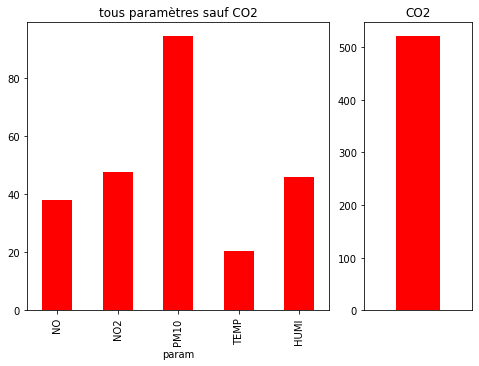

In [13]:
fig=plt.figure()
ax1=fig.add_axes([0,0,0.7,1])
df_air_global[df_air_global.columns[:-1]].mean().plot.bar(color='r')
ax1.set_title('tous paramètres sauf CO2')
ax2=fig.add_axes([0.78,0,0.25,1])
ax2.bar(1,df_air_global[df_air_global.columns[-1]].mean(),color='red',width=0.8)
ax2.set_xlim([0,2])
# df_air_global[df_air_global.columns[-1]].mean().plot.bar(ax=ax2,color=["tab:blue","tab:orange","tab:green"])
ax2.set_xticks([])
ax2.set_title('CO2');

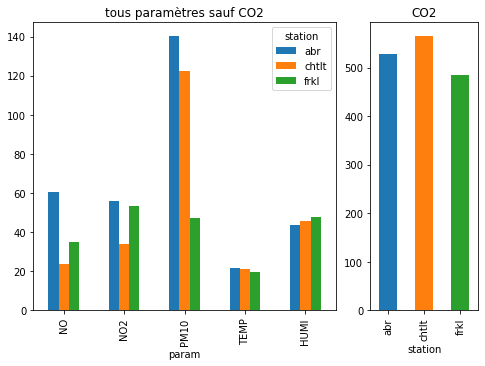

In [14]:
df_moy_global=df_air_global.groupby(df_air_global.index.get_level_values("station")).mean().transpose()
fig=plt.figure()
ax1=fig.add_axes([0,0,0.7,1])
# axes.bar(df_moy_global);
df_moy_global[:-1].plot.bar(ax=ax1)
ax1.set_title('tous paramètres sauf CO2')
ax2=fig.add_axes([0.78,0,0.25,1])
df_moy_global.iloc[-1].plot.bar(ax=ax2,color=["tab:blue","tab:orange","tab:green"])
ax2.set_title('CO2');

Chatelet est la station la moins exposée au N0 et au N02, tandis que franklin est la station la moins exposée au PM10. Les paramètres humidité, température et CO2 sont sensiblement identiques sur les 3 stations.

## **Evolution des concentrations par paramètres sur plusieurs échelles temporelles**
**(sur une station donnnée ou sur la moyenne des stations)**

In [15]:
def display_not_norm_VS_norm(data,par):
    fig=plt.figure(figsize=[13,4])
    plot_not_norm(fig,data,par)
    plot_norm(fig,data,par)
    return fig


def plot_not_norm(fig,data,par):
    
    ax1=fig.add_axes([0,0,0.46,0.85])
    
    if(par=='param'):
        #--Traçage de tous les paramètres sauf CO2
        c1=ax1.plot(data[df_air.columns[0:5]]); # on récupère la liste des objets 2Dline dans c1
        #--CO2 sur un autre axe y
        ax2 = ax1.twinx()
        c2=ax2.plot(data[data.columns[5]],'k')
        #--Miste en forme : légende et titre
        units=[" (µg/m3)"," (µg/m3)"," (µg/m3)"," (°C)"," (%)"," (ppm)"]
        labels=[data.columns[i]+units[i] for i in range(len(data.columns))]
        ax1.legend(c1+c2,labels,loc='best');
        plt.xticks(ticks=data.index.unique().sort_values());
        ax1.set_title('Données brutes - CO2 sur axe de droite')
        ax1.set_ylim([10,160])
        ax2.set_ylim([400,700])
        
    if(par=='station'):
        c1=ax1.plot(data); # on récupère la liste des objets 2Dline dans c1
        #--Miste en forme : légende et titre
        ax1.legend(c1,data.columns,loc='best');
        plt.xticks(ticks=data.index.unique().sort_values());
        ax1.set_title('Données brutes')
        ax1.set_ylim([10,160])
    
    return fig


def plot_norm(fig,data,par):
    
    ax1=fig.add_axes([0.54,0,0.46,0.85])
    
    if(par=='param'):
        #--Réduction des valeurs
        data=data/data.mean()
        #--Traçage de tous les paramètre
        c1=ax1.plot(data[df_air.columns[0:6]]);  #on récupère la liste des objets 2Dline dans c1
        c1[5].set_color('k')
        #--Miste en forme : légende et titre
        plt.xticks(ticks=data.index.unique().sort_values());
        plt.legend(c1,data.columns[0:6],loc='best');
        ax1.set_title('Données réduites')
        ax1.set_ylim([0.3,1.8])
        
    if(par=='station'):
        #--Réduction des valeurs
        data=data/data.mean()
        #--Traçage de tous les paramètre
        c1=ax1.plot(data)
        #--Miste en forme : légende et titre
        plt.xticks(ticks=data.index.unique().sort_values());
        plt.legend(c1,data.columns,loc='best');
        ax1.set_title('Données réduites')
        ax1.set_ylim([0.3,1.8])
    
    return fig

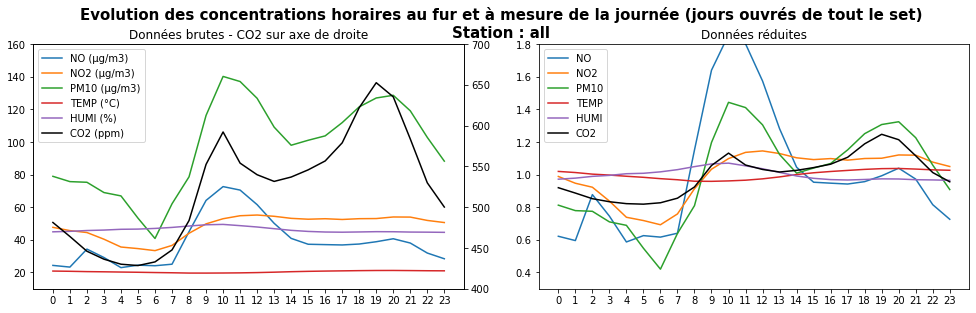

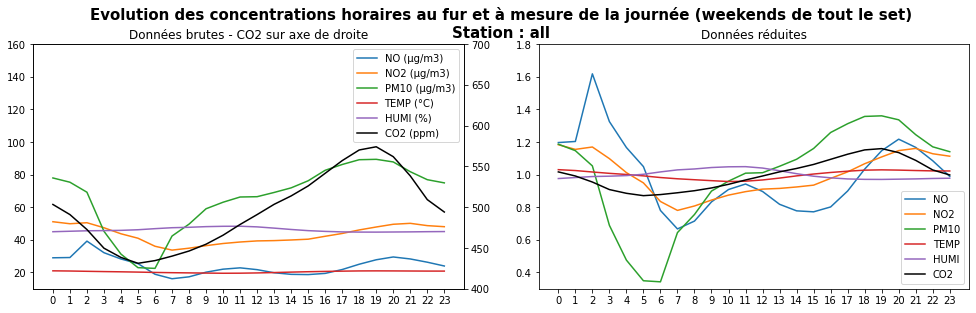

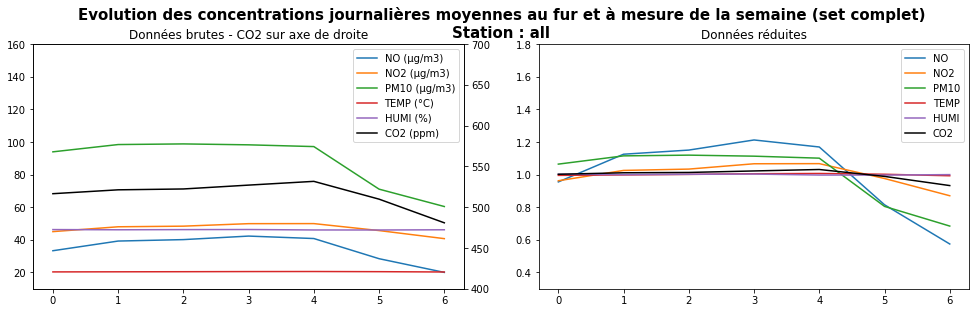

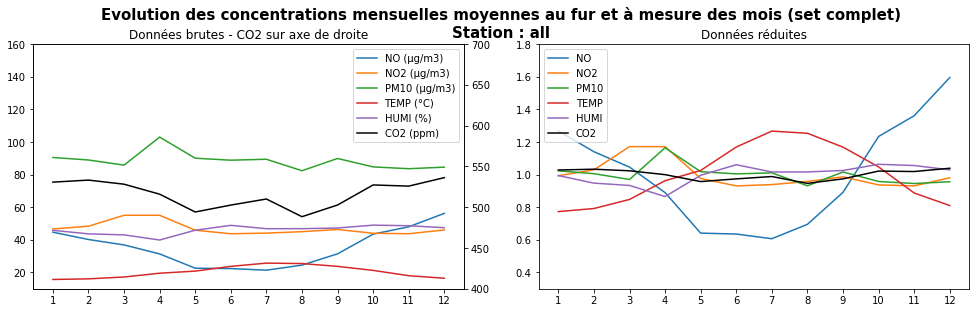

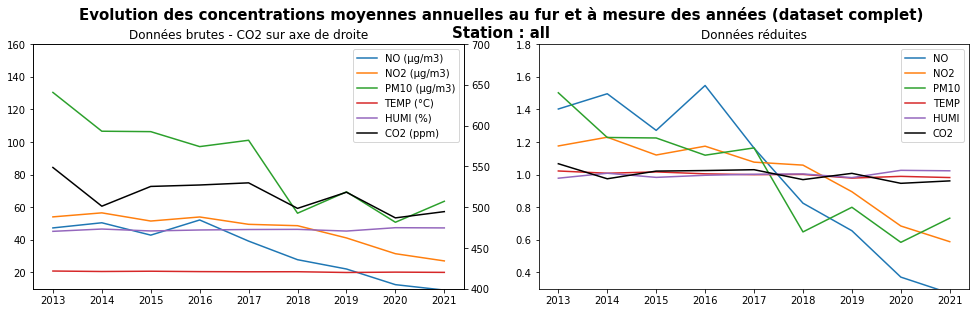

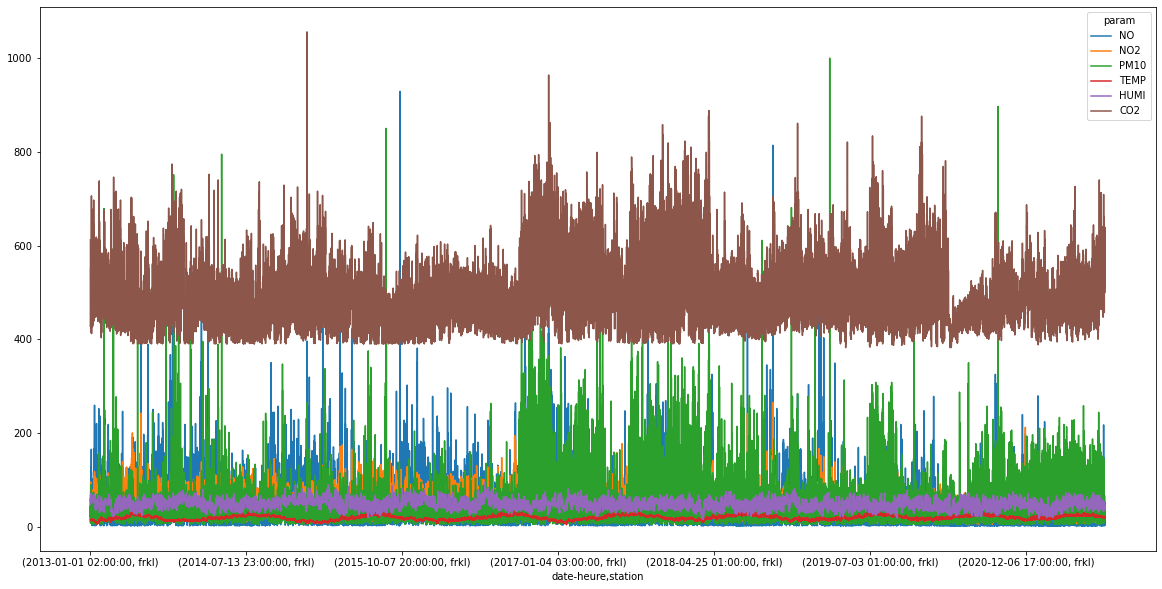

In [16]:
# sélectionner ci-dessous la station dont on veut afficher les paramètres
station='all' # 'all', 'abr', 'chtlt' ou 'frkl'

if station=='all':
    df_air=df_air_global.groupby(df_air_global.index.get_level_values("date-heure")).mean()
else:
    df_air=df_air_global.xs(station,level=1)

# Heures jours ouvrés
data=df_air.loc[df_air.index.weekday<=4].groupby(df_air.loc[df_air.index.weekday<=4].index.hour).mean()
fig=display_not_norm_VS_norm(data,par='param')
fig.suptitle(f'Evolution des concentrations horaires au fur et à mesure de la journée (jours ouvrés de tout le set)\nStation : {station}',fontweight='bold',fontsize=15);

# Heures weekends
data=df_air.loc[df_air.index.weekday>4].groupby(df_air.loc[df_air.index.weekday>4].index.hour).mean()
fig=display_not_norm_VS_norm(data,par='param')
fig.suptitle(f'Evolution des concentrations horaires au fur et à mesure de la journée (weekends de tout le set)\nStation : {station}',fontweight='bold',fontsize=15);

# Jours des mois
data=df_air.groupby(df_air.index.weekday).mean()
fig=display_not_norm_VS_norm(data,par='param')
fig.suptitle(f'Evolution des concentrations journalières moyennes au fur et à mesure de la semaine (set complet)\nStation : {station}',fontweight='bold',fontsize=15);

# Mois sur l'année
data=df_air.groupby(df_air.index.month).mean()
fig=display_not_norm_VS_norm(data,par='param')
fig.suptitle(f'Evolution des concentrations mensuelles moyennes au fur et à mesure des mois (set complet)\nStation : {station}',fontweight='bold',fontsize=15);

# Années
data=df_air.groupby(df_air.index.year).mean()
fig=display_not_norm_VS_norm(data,par='param')
fig.suptitle(f'Evolution des concentrations moyennes annuelles au fur et à mesure des années (dataset complet)\nStation : {station}',fontweight='bold',fontsize=15);
df_air_frkl.plot(figsize=[20,10]);

**Variations à court terme : au cours d'une même journée et au cours de la semaine**
- TEMP et HUMI : RAS
- CO2 et NO2 : variations non négligeables  (de l'ordre de 10-20%)
- NO et PM10 : variations significatives (de l'ordre de 40-50%)

**Variations à moyen terme : au cours de l'année**
- CO2, NO2 HUMI et PM10 : RAS
- TEMP : variations saisonnières non négligeables (de l'ordre de 20%)
- NO : variations saisonnières significatives (de l'ordre de 40%)

**Variations à long terme : au fil des ans**
- TEMP, HUMO, CO2 : RAS
- PM10, NO et NO2 : tendance baissière au fil des ans

## **Comparaison des  stations sur plusieurs échelles temporelles**
**(pour un paramètre donné)**

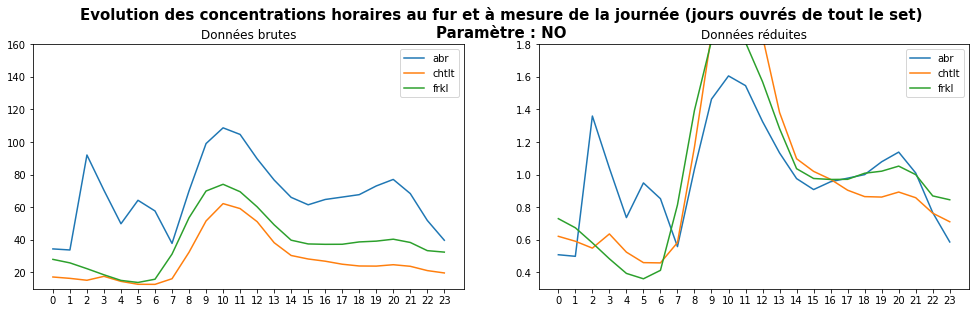

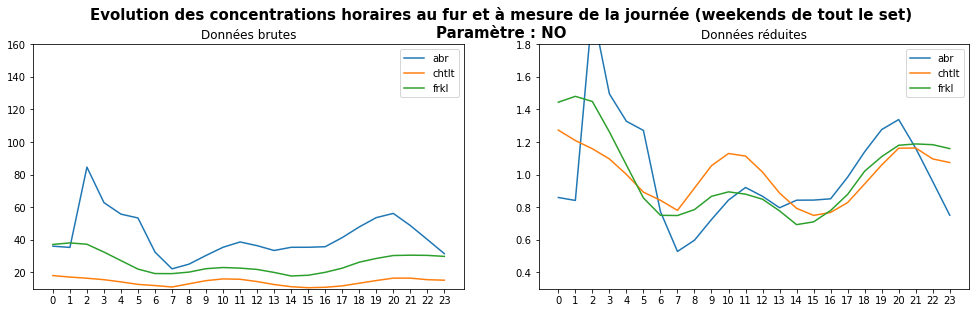

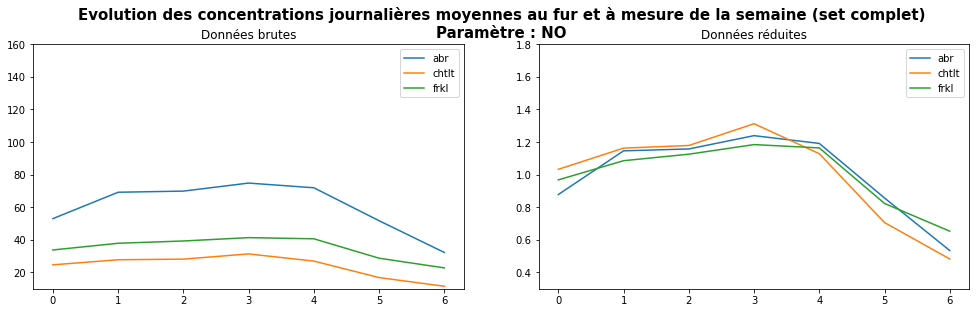

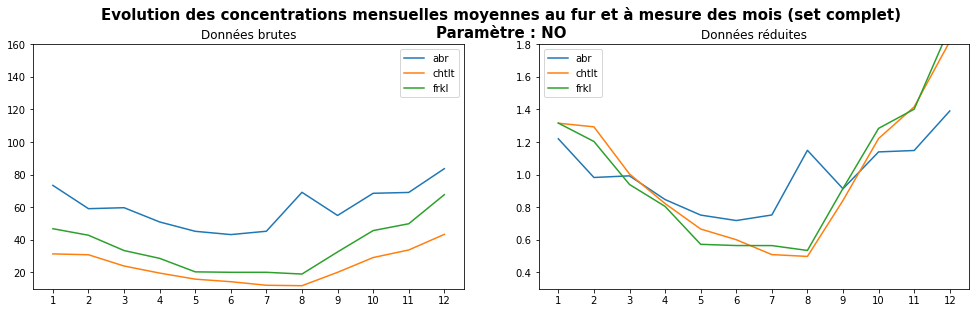

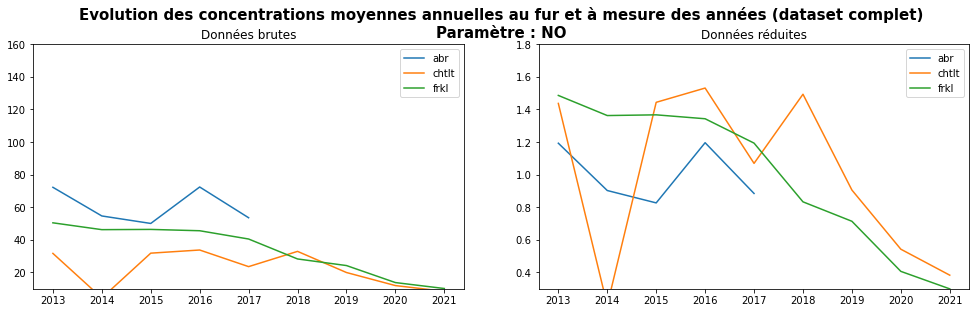

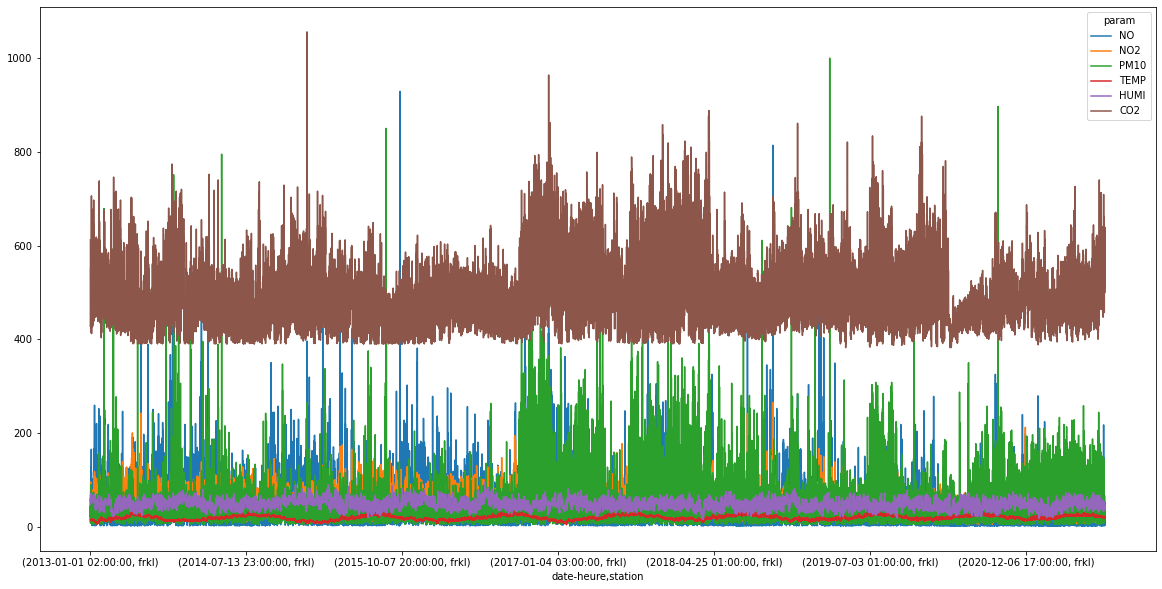

In [17]:
# sélectionner ci-dessous le paramètre à afficher
param='NO' # 'NO', 'NO2', 'PM10', 'TEMP', 'HUMI', 'CO2'

df_air=df_air_global[param].unstack()

# Heures jours ouvrés
data=df_air.loc[df_air.index.weekday<=4].groupby(df_air.loc[df_air.index.weekday<=4].index.hour).mean()
fig=display_not_norm_VS_norm(data,par='station')
fig.suptitle(f'Evolution des concentrations horaires au fur et à mesure de la journée (jours ouvrés de tout le set)\nParamètre : {param}',fontweight='bold',fontsize=15);

# Heures weekends
data=df_air.loc[df_air.index.weekday>4].groupby(df_air.loc[df_air.index.weekday>4].index.hour).mean()
fig=display_not_norm_VS_norm(data,par='station')
fig.suptitle(f'Evolution des concentrations horaires au fur et à mesure de la journée (weekends de tout le set)\nParamètre : {param}',fontweight='bold',fontsize=15);

# Jours des mois
data=df_air.groupby(df_air.index.weekday).mean()
fig=display_not_norm_VS_norm(data,par='station')
fig.suptitle(f'Evolution des concentrations journalières moyennes au fur et à mesure de la semaine (set complet)\nParamètre : {param}',fontweight='bold',fontsize=15);

# Mois sur l'année
data=df_air.groupby(df_air.index.month).mean()
fig=display_not_norm_VS_norm(data,par='station')
fig.suptitle(f'Evolution des concentrations mensuelles moyennes au fur et à mesure des mois (set complet)\nParamètre : {param}',fontweight='bold',fontsize=15);

# Années
data=df_air.groupby(df_air.index.year).mean()
fig=display_not_norm_VS_norm(data,par='station')
fig.suptitle(f'Evolution des concentrations moyennes annuelles au fur et à mesure des années (dataset complet)\nParamètre : {param}',fontweight='bold',fontsize=15);
df_air_frkl.plot(figsize=[20,10]);

En dehors des variations années après annnées qui présentent certaines incohérences, on remarque que toutes les variations listées dans la partie précédente sont bien communes aux 3 stations et relèvent donc de phénomènes à priori généralisables.

## **Premiers modèles de machine learning et data mining**

### **Prédiction de la valeur d'indicateurs de qualité de l'air**

#### **TOUTES STATIONS**

En regard de l'analyse du jeu de données effectuée précédemment, on tente d'élaborer un premier modèle rudimentaire visant à estimer la qualité de l'air dans le métro uniquement en fonction de la date et de l'heure.  
On considère que ces 3 stations de métro sont représentatives de l'ensemble des stations de métro parisiennes (on ne cherchera pas à différencier telle ou telle station)

In [18]:
df_air_model=df_air_global.droplevel(1,axis=0).reset_index()
df_air_model["year"]=df_air_model["date-heure"].dt.year
df_air_model["month"]=df_air_model["date-heure"].dt.month
df_air_model["weekday"]=df_air_model["date-heure"].dt.weekday
df_air_model["hour"]=df_air_model["date-heure"].dt.hour
df_air_model

param,date-heure,NO,NO2,PM10,TEMP,HUMI,CO2,year,month,weekday,hour
0,2013-01-01 02:00:00,23,41,26,15.1,65.6,612,2013,1,1,2
1,2013-01-01 03:00:00,43,61,18,14.9,65.0,536,2013,1,1,3
2,2013-01-01 04:00:00,22,52,45,14.9,63.3,490,2013,1,1,4
3,2013-01-01 05:00:00,27,56,22,14.9,63.7,481,2013,1,1,5
4,2013-01-01 06:00:00,27,57,15,15.0,63.3,464,2013,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...
151725,2017-12-15 00:00:00,12,36,189,16.6,45.5,448,2017,12,4,0
151726,2017-12-15 01:00:00,13,34,239,16.5,44.7,407,2017,12,4,1
151727,2017-12-15 02:00:00,49,32,187,16.1,44.5,407,2017,12,4,2
151728,2017-12-15 03:00:00,14,27,96,16.2,43.8,407,2017,12,4,3


In [19]:
X=df_air_model[["year","month","weekday","hour"]]
y=df_air_model["NO2"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values,y.values,test_size=0.33)

In [20]:
# recherche du nombre de voisins optimal par cross-validation
shuf_split=sklearn.model_selection.ShuffleSplit(5,test_size=0.33)
def score_func(k):
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(estimator=knn,X=X_train,y=y_train,cv=shuf_split)
    return np.mean(scores)

list_k=list(range(20,150,20))
scores_per_k=list(map(score_func, list_k))

le k optimal est : 40


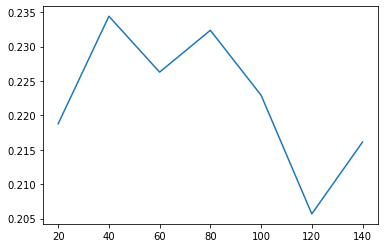

In [21]:
plt.plot(list_k,scores_per_k)
best_k=list_k[np.argmax(scores_per_k)]
print(f'le k optimal est : {best_k}')

In [22]:
# entrainement du modèle avec le k optimal et évaluation des prédictions
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=best_k).fit(X_train,y_train)
y_pred=knn.predict(X_test)
score_train=knn.score(X_train,y_train)
score_test=knn.score(X_test,y_test)
print(f'Score sur le jeu d\'entrainement : {score_train}')
print(f'Score sur le jeu de test : {score_test}')

Score sur le jeu d'entrainement : 0.273025948916753
Score sur le jeu de test : 0.23094610833904505


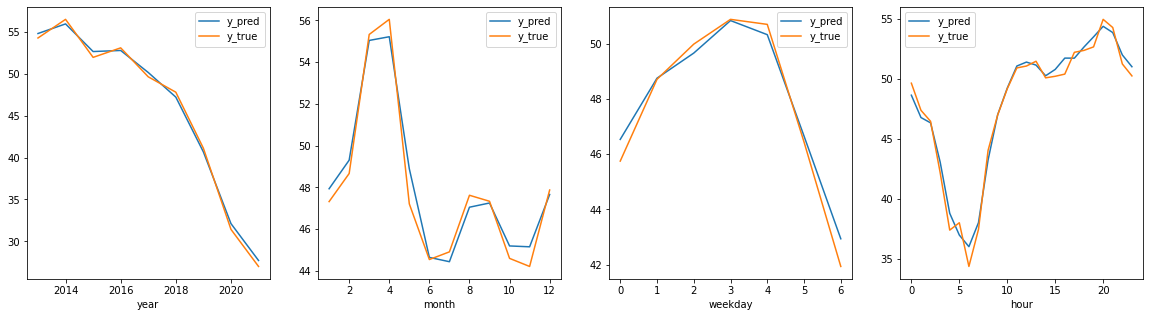

In [23]:
fig=plt.figure(figsize=[20,5])
axes=fig.subplots(1,4)
list_labels=["year","month","weekday","hour"]
for i in range(len(axes)):
    df_avg=pd.DataFrame(np.hstack([X_test[:,i].reshape(-1,1),y_pred.reshape(-1,1),y_test.reshape(-1,1)]),columns=[list_labels[i],"y_pred","y_true"])
    df_avg.groupby(list_labels[i]).mean().plot(ax=axes[i])

On voit ci-dessus que le modèle est assez bon pour prédire les concentrations en moyenne. Il manque cependant de variables explicatives pour effectuer une analyse plus fine.  
On notera également que par construction du modèle et de la méthodologie de validation, on se prive volontairement de la donnée "station", ce qui est à l'origine d'une erreur incompressible.

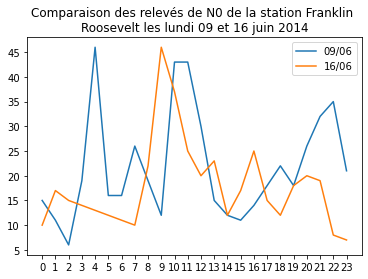

In [24]:
df_J1=df_air_global.loc[(df_air_global.index.get_level_values("date-heure")>=datetime.datetime(2014,6,9)) & (df_air_global.index.get_level_values("date-heure")<datetime.datetime(2014,6,10))]
df_J2=df_air_global.loc[(df_air_global.index.get_level_values("date-heure")>=datetime.datetime(2014,6,16)) & (df_air_global.index.get_level_values("date-heure")<datetime.datetime(2014,6,17))]
df_J1_frkl=df_J1.loc[df_J1.index.get_level_values("station")=="frkl"]
df_J2_frkl=df_J2.loc[df_J2.index.get_level_values("station")=="frkl"]
plt.plot(df_J1_frkl.index.get_level_values("date-heure").hour,df_J1_frkl["NO"].values,label='09/06')
plt.plot(df_J2_frkl.index.get_level_values("date-heure").hour,df_J2_frkl["NO"].values,label='16/06')
plt.xticks(df_J1_frkl.index.get_level_values("date-heure").hour);
plt.title("Comparaison des relevés de N0 de la station Franklin \nRoosevelt les lundi 09 et 16 juin 2014")
plt.legend();

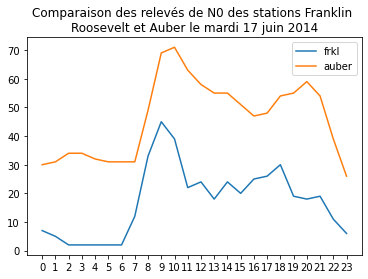

In [25]:
day=17
df_J=df_air_global.loc[(df_air_global.index.get_level_values("date-heure")>=datetime.datetime(2014,6,day)) & (df_air_global.index.get_level_values("date-heure")<datetime.datetime(2014,6,day+1))]
df_J_frkl=df_J.loc[df_J.index.get_level_values("station")=="frkl"]
df_J_abr=df_J.loc[df_J.index.get_level_values("station")=="abr"]
plt.plot(df_J_frkl.index.get_level_values("date-heure").hour,df_J_frkl["NO"].values,label='frkl')
plt.plot(df_J_abr.index.get_level_values("date-heure").hour,df_J_abr["NO"].values,label='auber')
plt.xticks(df_J_frkl.index.get_level_values("date-heure").hour);
plt.title("Comparaison des relevés de N0 des stations Franklin \nRoosevelt et Auber le mardi 17 juin 2014")
plt.legend();

#### **FRANKLIN**

In [26]:
# amélioration du modèle tout en un
df_air_model=df_air_global.xs('frkl',level=1).reset_index()
df_air_model["year"]=df_air_model["date-heure"].dt.year
df_air_model["month"]=df_air_model["date-heure"].dt.month
df_air_model["weekday"]=df_air_model["date-heure"].dt.weekday
df_air_model["hour"]=df_air_model["date-heure"].dt.hour
X=df_air_model[["year","month","weekday","hour"]]
y=df_air_model["NO2"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values,y.values,test_size=0.33)

In [27]:
df_air_model[df_air_model.columns[[7,8,9,10,2]]]

param,year,month,weekday,hour,NO2
0,2013,1,1,2,41
1,2013,1,1,3,61
2,2013,1,1,4,52
3,2013,1,1,5,56
4,2013,1,1,6,57
...,...,...,...,...,...
65042,2021,10,6,22,37
65043,2021,10,6,23,40
65044,2021,10,0,0,44
65045,2021,10,0,1,46


In [28]:
# recherche du nombre de voisins optimal par cross-validation
shuf_split=sklearn.model_selection.ShuffleSplit(5,test_size=0.33)
def score_func(k):
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(estimator=knn,X=X_train,y=y_train,cv=shuf_split)
    return np.mean(scores)

list_k=list(range(1,80,3))
scores_per_k=list(map(score_func, list_k))

le k optimal est : 13


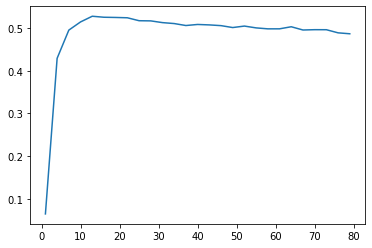

In [29]:
plt.plot(list_k,scores_per_k)
best_k=list_k[np.argmax(scores_per_k)]
print(f'le k optimal est : {best_k}')

In [30]:
# entrainement du modèle avec le k optimal et évaluation des prédictions
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=best_k).fit(X_train,y_train)
y_pred=knn.predict(X_test)
score_train=knn.score(X_train,y_train)
score_test=knn.score(X_test,y_test)
print(f'Score sur le jeu d\'entrainement : {score_train}')
print(f'Score sur le jeu de test : {score_test}')

Score sur le jeu d'entrainement : 0.5938085962440556
Score sur le jeu de test : 0.5436469634835599


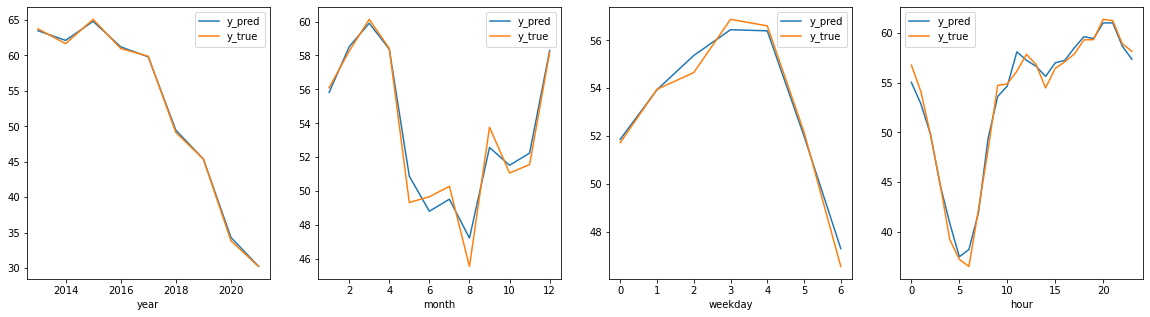

In [31]:
fig=plt.figure(figsize=[20,5])
axes=fig.subplots(1,4)
list_labels=["year","month","weekday","hour"]
for i in range(len(axes)):
    df_avg=pd.DataFrame(np.hstack([X_test[:,i].reshape(-1,1),y_pred.reshape(-1,1),y_test.reshape(-1,1)]),columns=[list_labels[i],"y_pred","y_true"])
    df_avg.groupby(list_labels[i]).mean().plot(ax=axes[i])

### **Discrimination des jours-ouvrés et weekends en fonction des relevés de qualité de l'air**

#### **TOUTES STATIONS**

Les algorithmes de classification que nous connaissons (kmeans,k-voisins) sont toutes soumises à la malédiction de la dimension car basés sur des calculs de distance. Or, si l'on voulait rassembler toutes les valeurs dont on dispose pour chaque journée, on récupèrerait un vecteur de taille 24 heures * 6 paramètres = 144 paramètres. Il est donc fort probable que les algorithmes soient inefficaces.  
Pour éviter ce problème, on tente de simplifier le modèle en remplaçant les 24 valeurs horaires pour chaque variable par leur moyenne et leur écart type sur les 3 stations réunies.

In [32]:
df_air_model=df_air_global[["NO","NO2","PM10","CO2"]]
df_air_model=df_air_model.groupby(df_air_model.index.get_level_values("date-heure").date).agg(['mean','var'])
df_air_model.index=pd.to_datetime(df_air_model.index)
df_air_model=df_air_model.reset_index(drop=False)
df_air_model["index"]=df_air_model["index"].dt.weekday
df_air_model["weekend"]=df_air_model["index"].apply(lambda x : x in [5,6])
df_air_model=df_air_model.dropna()
df_air_model

param index         NO                     NO2                    PM10  \
                  mean          var       mean         var        mean   
0         1  23.386364   318.707717  51.000000  352.186047   84.500000   
1         2  54.583333  1380.418440  57.625000  241.218085  101.770833   
2         3  51.937500  1571.676862  50.000000  206.893617   86.562500   
3         4  41.054545   927.830303  51.127273  215.409428  108.163636   
4         5  32.166667  1024.281690  39.513889  135.661776  136.763889   
...     ...        ...          ...        ...         ...         ...   
3076      3  76.145833  4887.191046  61.187500  157.006649   71.312500   
3077      4  40.458333  1192.721631  57.541667  230.764184   67.354167   
3078      5   8.437500    18.804521  35.166667   40.482270   43.979167   
3079      6   8.791667    52.168440  39.104167  255.584663   39.937500   
3080      0   5.666667     4.266667  33.166667  159.766667   40.000000   

param                       CO2               weekend  
                var        mean           var          
0       4553.883721  567.181818  12461.035941   False  
1       7152.691046  570.583333  16648.801418   False  
2       6465.783245  574.312500  19953.070479   False  
3      21162.731987  578.618182  14485.092256   False  
4      23711.732199  522.958333   8891.646127    True  
...             ...         ...           ...     ...  
3076    1290.602394  584.791667   4231.828014   False  
3077    1004.191046  568.854167   6073.233599   False  
3078     714.361259  537.791667   4550.423759    True  
3079     340.613032  535.583333   2992.120567    True  
3080      29.600000  498.666667    479.866667   False  

[3079 rows x 10 columns]

In [33]:
print(f'Pourcentage de jours du dataset étant des jours du weekend : {round(np.min(df_air_model["weekend"].value_counts())/len(df_air_model)*100,1)} %')

Pourcentage de jours du dataset étant des jours du weekend : 28.2 %


#### Approche par clustering

In [34]:
kmeans_algo = sklearn.cluster.KMeans(n_clusters=2)
kmeans_algo.fit(df_air_model[df_air_model.columns[1:9]].values)
pred_weekend=kmeans_algo.labels_

In [35]:
# répartition des valeurs prédites :
val,count=np.unique(pred_weekend,return_counts=True)
print(f'Pourcentage de jours classifiés avec l\'étiquette la moins fréquente : {round(np.min(count)/len(pred_weekend)*100,1)} %')

Pourcentage de jours classifiés avec l'étiquette la moins fréquente : 15.6 %


In [36]:
# % de cas où le cluster attribué correspond à la qualité semaine/weekend
print(f'{round(np.sum(pred_weekend==df_air_model["weekend"].values)/len(pred_weekend)*100,1)} %')

58.4 %


#### Approche par classification supervisée

In [37]:
X=df_air_model[df_air_model.columns[1:9]]
y=df_air_model["weekend"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values,y.values,test_size=0.33)

In [38]:
# recherche du nombre de voisins optimal par cross-validation
shuf_split=sklearn.model_selection.ShuffleSplit(100,test_size=0.33)
def score_func(k):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(estimator=knn,X=X_train,y=y_train,cv=shuf_split)
    return np.mean(scores)

list_k=list(range(10,230,20))
scores_per_k=list(map(score_func, list_k))

le k optimal est : 30


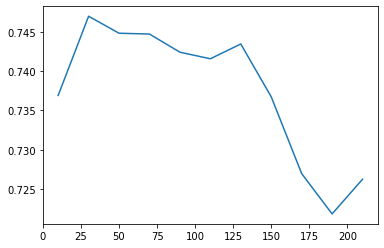

In [39]:
plt.plot(list_k,scores_per_k)
best_k=list_k[np.argmax(scores_per_k)]
print(f'le k optimal est : {best_k}')

In [40]:
# entrainement du modèle avec le k optimal et évaluation des prédictions
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
y_pred=knn.predict(X_test)
score_train=knn.score(X_train,y_train)
score_test=knn.score(X_test,y_test)
print(f'Score sur le jeu d\'entrainement : {score_train}')
print(f'Score sur le jeu de test : {score_test}')

Score sur le jeu d'entrainement : 0.7623666343355965
Score sur le jeu de test : 0.7512291052114061


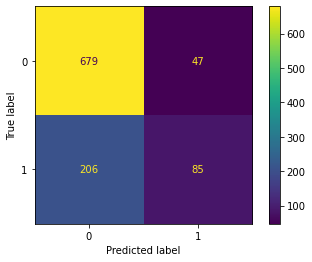

In [41]:
disp=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test,y_pred))
disp.plot();

In [42]:
sklearn.metrics.f1_score(y_test,y_pred)

0.40189125295508277

Le "bon" score de précision (0.76) est notamment dû au fait que les classes soient assez déséquilibrée.  
Dans le détail, la matrice de confusion ainsi que le f1 score montrent que le modèle n'est pas très performant.

#### **FRANKLIN**

In [43]:
df_air_model=df_air_global[["NO","NO2","PM10","CO2"]]
df_air_model=df_air_model.xs('frkl',level=1)
df_air_model=df_air_model.groupby(df_air_model.index.get_level_values("date-heure").date).agg(['mean','var'])
df_air_model.index=pd.to_datetime(df_air_model.index)
df_air_model=df_air_model.reset_index(drop=False)
df_air_model["index"]=df_air_model["index"].dt.weekday
df_air_model["weekend"]=df_air_model["index"].apply(lambda x : x in [5,6])
df_air_model=df_air_model.dropna()
df_air_model

param index         NO                     NO2                   PM10  \
                  mean          var       mean         var       mean   
0         1  30.636364   342.337662  62.227273  304.279221  21.227273   
1         2  62.333333  1368.492754  67.708333  172.476449  41.333333   
2         3  60.791667  1728.606884  58.875000  188.635870  28.750000   
3         4  45.458333   471.824275  63.625000  117.461957  31.666667   
4         5  26.541667   426.172101  52.208333   70.954710  26.833333   
...     ...        ...          ...        ...         ...        ...   
2840      3  67.833333  3339.449275  57.625000   70.853261  65.083333   
2841      4  45.750000  1281.065217  57.000000  108.434783  59.666667   
2842      5   9.583333    25.557971  37.791667   32.954710  32.666667   
2843      6   9.291667    60.563406  41.583333  232.862319  36.041667   
2844      0   7.333333     2.333333  44.666667    1.333333  37.000000   

param                      CO2              weekend  
               var        mean          var          
0       118.945887  483.772727  2267.136364   False  
1       404.405797  500.833333  2699.101449   False  
2       169.152174  504.041667  5942.128623   False  
3       339.362319  516.375000  7375.027174   False  
4       185.449275  491.541667  2573.998188    True  
...            ...         ...          ...     ...  
2840   1432.079710  573.041667  2359.693841   False  
2841   1060.666667  557.041667  2571.693841   False  
2842    242.666667  531.833333  3138.057971    True  
2843    120.215580  559.791667  2320.085145    True  
2844     19.000000  516.666667    25.333333   False  

[2842 rows x 10 columns]

In [44]:
print(f'Pourcentage de jours du dataset étant des jours du weekend : {round(np.min(df_air_model["weekend"].value_counts())/len(df_air_model)*100,1)} %')

Pourcentage de jours du dataset étant des jours du weekend : 27.6 %


#### Approche par clustering

In [45]:
kmeans_algo = sklearn.cluster.KMeans(n_clusters=2)
kmeans_algo.fit(df_air_model[df_air_model.columns[1:9]].values)
pred_weekend=kmeans_algo.labels_

In [46]:
# répartition des valeurs prédites :
val,count=np.unique(pred_weekend,return_counts=True)
print(f'Pourcentage de jours classifiés avec l\'étiquette la moins fréquente : {round(np.min(count)/len(pred_weekend)*100,1)} %')

Pourcentage de jours classifiés avec l'étiquette la moins fréquente : 10.8 %


In [47]:
# % de cas où le cluster attribué correspond à la qualité semaine/weekend
print(f'{round(np.sum(pred_weekend==df_air_model["weekend"].values)/len(pred_weekend)*100,1)} %')

37.6 %


#### Approche par classification supervisée

In [48]:
X=df_air_model[df_air_model.columns[1:9]]
y=df_air_model["weekend"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values,y.values,test_size=0.33)

In [49]:
# recherche du nombre de voisins optimal par cross-validation
shuf_split=sklearn.model_selection.ShuffleSplit(100,test_size=0.33)
def score_func(k):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(estimator=knn,X=X_train,y=y_train,cv=shuf_split)
    return np.mean(scores)

list_k=list(range(10,230,20))
scores_per_k=list(map(score_func, list_k))

le k optimal est : 10


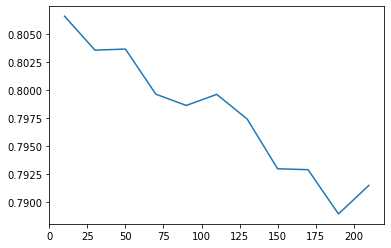

In [50]:
plt.plot(list_k,scores_per_k)
best_k=list_k[np.argmax(scores_per_k)]
print(f'le k optimal est : {best_k}')

In [51]:
# entrainement du modèle avec le k optimal et évaluation des prédictions
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
y_pred=knn.predict(X_test)
score_train=knn.score(X_train,y_train)
score_test=knn.score(X_test,y_test)
print(f'Score sur le jeu d\'entrainement : {score_train}')
print(f'Score sur le jeu de test : {score_test}')

Score sur le jeu d'entrainement : 0.8167016806722689
Score sur le jeu de test : 0.8038379530916845


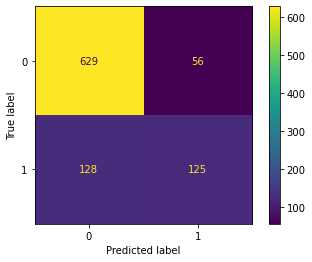

In [52]:
disp=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test,y_pred))
disp.plot();

In [53]:
sklearn.metrics.f1_score(y_test,y_pred)

0.5760368663594471

#### **TOUTES STATIONS AVEC RETRAVAIL DES DONNEES**

On commence par diviser les valeurs de chaque jour par la moyenne de concentration de la journée pour transformer les valeurs en variations en % autour de la moyenne.  
Les autres modifs sont détaillées au niveau du code

In [54]:
# version 1 : avec un argmax global moyen (moins bon)

# calcul de la variance journalière pour chaque couple paramètre-station
df_air_model=df_air_global[["NO","NO2","PM10","CO2"]]
df_air_model=df_air_model.groupby([df_air_model.index.get_level_values("date-heure").date,df_air_model.index.get_level_values("station")]).transform(lambda sub_df: sub_df.div(sub_df.mean()))
df_air_model=df_air_model.groupby([df_air_model.index.get_level_values("date-heure").date,df_air_model.index.get_level_values("station")]).var()
df_air_model.index=df_air_model.index.set_names("date-heure",level=0)
df_air_model["weekday"]=pd.to_datetime(df_air_model.index.get_level_values("date-heure")).weekday
df_air_model["weekend"]=df_air_model["weekday"].apply(lambda x : x in [5,6])
df_air_model=df_air_model.dropna()

# calcul de l'heure du pic de concentration global tous paramètres confondus
def return_hour_max(sub_df):
    return sub_df.mean(axis=1).sort_values().tail(1).index.get_level_values("date-heure").hour.values.squeeze()
df_air_model_part_2=df_air_global.groupby([df_air_global.index.get_level_values("date-heure").date,df_air_global.index.get_level_values("station")]).apply(return_hour_max)
df_air_model_part_2.index=df_air_model_part_2.index.set_names("date-heure",level=0)
df_air_model_part_2=df_air_model_part_2.rename("arg_max")

# réunion des deux dataframes
df_air_model=df_air_model.join(df_air_model_part_2)

# variables explicatives et variable expliquée
X=df_air_model[df_air_model.columns[[0,1,2,3,6]]]
y=df_air_model["weekend"]

# la normalisation améliore les performances de la classification mais altère les performances du clustering
scaler = sklearn.preprocessing.StandardScaler()
X=scaler.fit_transform(X)

In [55]:
# version 2 : avec calcul de l'heure du pic pour chaque paramètre (meilleur)

# calcul de la variance journalière pour chaque couple paramètre-station
df_air_model=df_air_global[["NO","NO2","PM10","CO2"]]
df_air_model=df_air_model.groupby([df_air_model.index.get_level_values("date-heure").date,df_air_model.index.get_level_values("station")]).transform(lambda sub_df: sub_df.div(sub_df.mean()))
df_air_model=df_air_model.groupby([df_air_model.index.get_level_values("date-heure").date,df_air_model.index.get_level_values("station")]).var()
df_air_model.index=df_air_model.index.set_names("date-heure",level=0)
df_air_model["weekday"]=pd.to_datetime(df_air_model.index.get_level_values("date-heure")).weekday
df_air_model["weekend"]=df_air_model["weekday"].apply(lambda x : x in [5,6])
df_air_model=df_air_model.dropna()
df_air_model

# calcul de l'heure du pic de concentration pour chaque paramètre
def return_hour_max(sub_df,param):
    return sub_df.sort_values(param).tail(1).index.get_level_values("date-heure").hour.values.squeeze()
df_air_model_part_2=pd.DataFrame({})
for param in ["NO","NO2","PM10","CO2"]:
    df_air_model_part_2_new=df_air_global.groupby([df_air_global.index.get_level_values("date-heure").date,df_air_global.index.get_level_values("station")]).apply(lambda sub_df : return_hour_max(sub_df,param))
    df_air_model_part_2=pd.concat([df_air_model_part_2,df_air_model_part_2_new],axis=1)
df_air_model_part_2.index=df_air_model_part_2.index.set_names(["date-heure","station"])
df_air_model_part_2.columns=["NO_argmax","NO2_argmax","PM10_argmax","CO2_argmax"]
df_air_model_part_2

# réunion des deux dataframes
df_air_model=df_air_model.join(df_air_model_part_2)

# variables explicatives et variable expliquée
X=df_air_model[df_air_model.columns[[0,1,2,3,6,7,8,9]]].values
y=df_air_model["weekend"].values

# la normalisation améliore les performances de la classification mais altère les performances du clustering
scaler = sklearn.preprocessing.StandardScaler()
X=scaler.fit_transform(X)

In [56]:
df_air_model[df_air_model.columns[[0,1,2,3,6,7,8,9,5]]]

NO       NO2      PM10       CO2 NO_argmax  \
date-heure station                                                     
2013-01-01 chtlt    0.768575  0.096566  0.037438  0.020487        19   
           frkl     0.364737  0.078580  0.263974  0.009687        18   
2013-01-02 chtlt    0.605014  0.047898  0.250421  0.051629         9   
           frkl     0.352210  0.037622  0.236710  0.010761        20   
2013-01-03 chtlt    0.710855  0.041251  0.291129  0.059030        10   
...                      ...       ...       ...       ...       ...   
2021-10-16 frkl     0.278287  0.023074  0.227405  0.011095        13   
2021-10-17 chtlt    0.662091  0.206198  0.283208  0.009832         6   
           frkl     0.701493  0.134667  0.092545  0.007404         5   
2021-10-18 chtlt    0.000000  0.002840  0.015143  0.000876         2   
           frkl     0.043388  0.000668  0.013879  0.000095         2   

                   NO2_argmax PM10_argmax CO2_argmax  weekend  
date-heure station                                             
2013-01-01 chtlt           20          18          3    False  
           frkl            20          18          2    False  
2013-01-02 chtlt            9          20         19    False  
           frkl            20          11         19    False  
2013-01-03 chtlt           21          11         19    False  
...                       ...         ...        ...      ...  
2021-10-16 frkl            15           0         19     True  
2021-10-17 chtlt            5          21         21     True  
           frkl             4           0         13     True  
2021-10-18 chtlt            0           0          0    False  
           frkl             1           0          0    False  

[6603 rows x 9 columns]

In [57]:
print(f'Pourcentage de jours du dataset étant des jours du weekend : {round(np.min(df_air_model["weekend"].value_counts())/len(df_air_model)*100,1)} %')

Pourcentage de jours du dataset étant des jours du weekend : 27.7 %


#### Approche par clustering

In [58]:
kmeans_algo = sklearn.cluster.KMeans(n_clusters=2)
kmeans_algo.fit(X)
pred_weekend=kmeans_algo.labels_

In [59]:
# répartition des valeurs prédites :
val,count=np.unique(pred_weekend,return_counts=True)
print(f'Pourcentage de jours classifiés avec l\'étiquette la moins fréquente : {round(np.min(count)/len(pred_weekend)*100,1)} %')

Pourcentage de jours classifiés avec l'étiquette la moins fréquente : 34.7 %


In [60]:
# % de cas où le cluster attribué correspond à la qualité semaine/weekend
print(f'{round(np.sum(pred_weekend==df_air_model["weekend"].values)/len(pred_weekend)*100,1)} %')

39.3 %


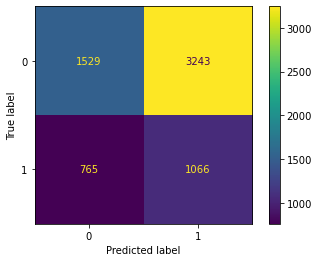

In [61]:
disp=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y,pred_weekend))
disp.plot();

#### Approche par classification supervisée

In [62]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.33)

In [63]:
# recherche du nombre de voisins optimal par cross-validation
shuf_split=sklearn.model_selection.ShuffleSplit(50,test_size=0.33)
def score_func(k):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(estimator=knn,X=X_train,y=y_train,cv=shuf_split)
    return np.mean(scores)

list_k=list(range(2,31,2))
scores_per_k=list(map(score_func, list_k))

le k optimal est : 8


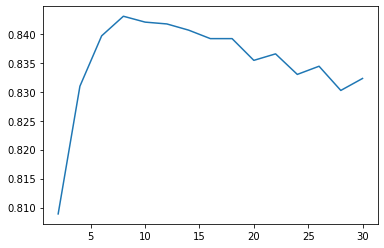

In [64]:
plt.plot(list_k,scores_per_k)
best_k=list_k[np.argmax(scores_per_k)]
print(f'le k optimal est : {best_k}')

In [65]:
# entrainement du modèle avec le k optimal et évaluation des prédictions
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
y_pred=knn.predict(X_test)
score_train=knn.score(X_train,y_train)
score_test=knn.score(X_test,y_test)
print(f'Score sur le jeu d\'entrainement : {score_train}')
print(f'Score sur le jeu de test : {score_test}')

Score sur le jeu d'entrainement : 0.8496835443037974
Score sur le jeu de test : 0.8398347865993575


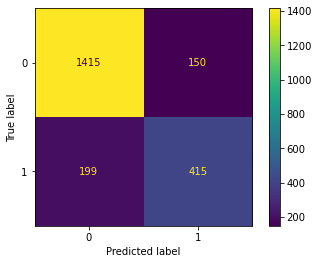

In [66]:
disp=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test,y_pred))
disp.plot();

In [67]:
sklearn.metrics.f1_score(y_test,y_pred)

0.7039864291772688